# Задача 3.1

<ipython-input-16-df764d9b4f6c>:19: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv('sales.csv', parse_dates=['purchase_date'])


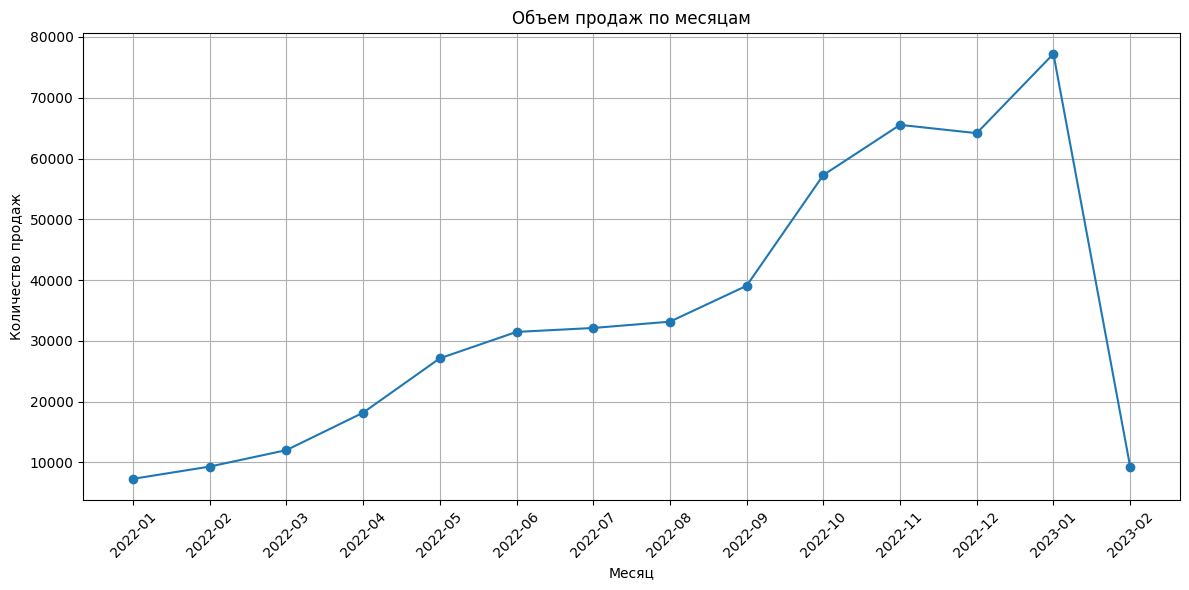

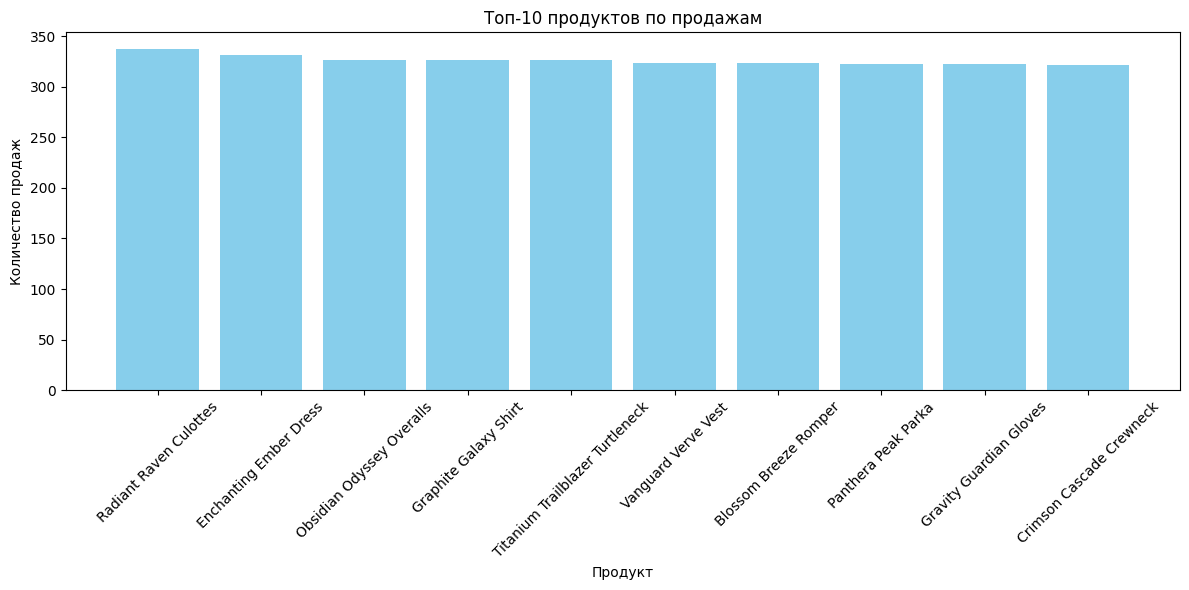

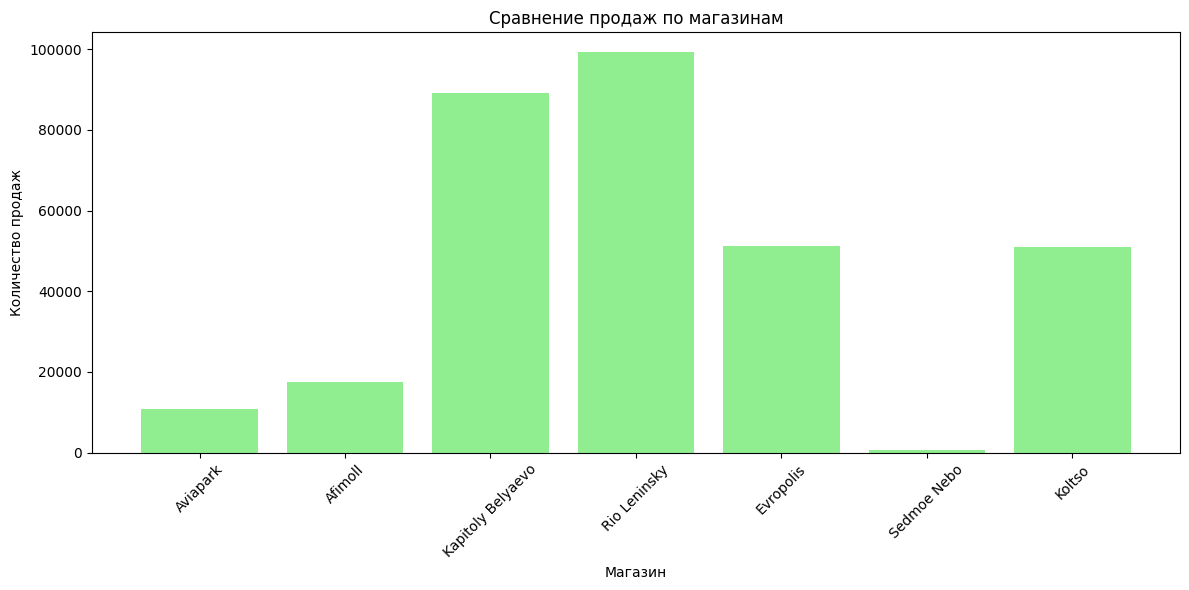

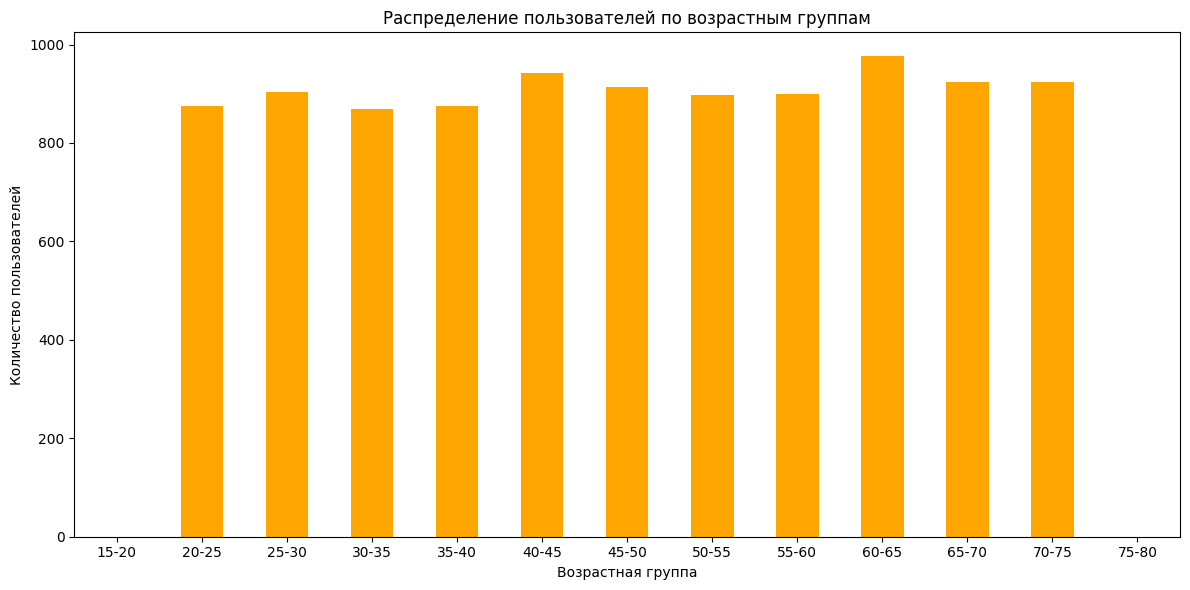

Количество новых пользователей: 7370
Количество активных пользователей: 8406
Средний чек: 230009.76
Повторные покупки: 8228 клиентов (97.88%)
Конверсия продаж: 328.57%
VIP клиенты: 8405
Среднее количество заказов на клиента: 17.15
Средняя сумма заказов на клиента: 13884125.11


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные из orders.csv с указанием типов данных как object
orders_df = pd.read_csv('orders.csv', sep=',', dtype=str)

# Преобразуем столбец order_date в формат datetime
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')

# Заполняем пропущенные значения в числовых столбцах и преобразуем их в int
orders_df['order_id'] = orders_df['order_id'].astype(int)
orders_df['user_id'] = orders_df['user_id'].fillna(0).astype(int)
orders_df['store_id'] = orders_df['store_id'].fillna(0).astype(int)

# Извлекаем месяц и год из даты заказа
orders_df['month_year'] = orders_df['order_date'].dt.to_period('M')

# Загружаем другие наборы данных
sales_df = pd.read_csv('sales.csv', parse_dates=['purchase_date'])

# Обрабатываем значения NA в булевых столбцах
sales_df['is_canceled'].fillna(False, inplace=True)
sales_df['is_accepted'].fillna(False, inplace=True)

# Преобразуем булевые столбцы в правильный тип
sales_df['is_canceled'] = sales_df['is_canceled'].astype(bool)
sales_df['is_accepted'] = sales_df['is_accepted'].astype(bool)

store_df = pd.read_csv('store.csv', parse_dates=['store_open_date', 'store_close_date'])
user_df = pd.read_csv('user.csv', parse_dates=['user_birthdate'])
product_df = pd.read_csv('product.csv')

# Рассчитываем общее количество заказов и сумму продаж
total_orders = orders_df['order_id'].nunique()
total_sales_amount = sales_df[sales_df['is_canceled'] == False]['id'].count()  # Используем count для суммы продаж

# Объединяем данные о продажах с заказами для получения сумм продаж на заказ
merged_df = pd.merge(orders_df, sales_df, left_on='order_id', right_on='order_id')

# Группируем по месяцам и годам для получения общего объема продаж за месяц
monthly_sales = merged_df.groupby('month_year')['id'].count().reset_index()
monthly_sales.columns = ['Month', 'Sales']

# Построение графика месячных продаж
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Sales'], marker='o')
plt.title('Объем продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Извлекаем информацию о продуктах и рассчитываем общие продажи для каждого продукта
product_sales = sales_df[sales_df['is_canceled'] == False].groupby('product_id')['id'].count().reset_index()
product_sales.columns = ['product_id', 'total_sales']

# Объединяем с product_df для получения названий продуктов
product_sales = pd.merge(product_sales, product_df, on='product_id')

# Получаем топ-10 продуктов по продажам
top_10_products = product_sales.sort_values(by='total_sales', ascending=False).head(10)

# Построение графика топ-10 продуктов
plt.figure(figsize=(12, 6))
plt.bar(top_10_products['product_name'], top_10_products['total_sales'], color='skyblue')
plt.title('Топ-10 продуктов по продажам')
plt.xlabel('Продукт')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Объединяем данные о заказах с данными о продажах для получения store_id для каждой продажи
merged_sales_df = pd.merge(sales_df[sales_df['is_canceled'] == False], orders_df[['order_id', 'store_id']], on='order_id')

# Рассчитываем продажи по магазинам
store_sales = merged_sales_df.groupby('store_id')['id'].count().reset_index()
store_sales.columns = ['store_id', 'total_sales']

# Объединяем с store_df для получения названий магазинов
store_sales = pd.merge(store_sales, store_df, on='store_id')

# Построение графика продаж по магазинам
plt.figure(figsize=(12, 6))
plt.bar(store_sales['store_name'], store_sales['total_sales'], color='lightgreen')
plt.title('Сравнение продаж по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Рассчитываем количество новых пользователей (предполагаем, что столбец 'status' указывает новых пользователей, если status = 'accepted')
new_users_count = user_df[user_df['status'] == 'accepted'].shape[0]

# Рассчитываем количество активных пользователей (предполагаем, что наличие заказов указывает на активных пользователей)
active_users_count = orders_df['user_id'].nunique()

# Средний чек
merged_df = pd.merge(orders_df, sales_df, left_on='order_id', right_on='order_id')
average_order_value = merged_df[merged_df['is_canceled'] == False]['id'].mean()

# Повторные покупки
repeat_customers = orders_df['user_id'].value_counts()[orders_df['user_id'].value_counts() > 1].count()
total_customers = orders_df['user_id'].nunique()
repeat_purchase_rate = (repeat_customers / total_customers) * 100

# Конверсия продаж
accepted_orders = sales_df[sales_df['is_accepted'] == True]['order_id'].nunique()
total_orders = orders_df['order_id'].nunique()
conversion_rate = (accepted_orders / total_orders) * 100

# Клиентская база
total_spent_per_customer = merged_df.groupby('user_id')['id'].sum()
vip_customers = total_spent_per_customer[total_spent_per_customer > 100000].count()  # Примерная граница для VIP клиентов

# Анализ вовлеченности клиентов
average_orders_per_customer = orders_df['order_id'].nunique() / total_customers
average_spent_per_customer = total_spent_per_customer.mean()

# Рассчитываем распределение пользователей по возрасту
current_year = pd.Timestamp('now').year
user_df['age'] = current_year - user_df['user_birthdate'].dt.year

# Группируем пользователей по возрастным категориям
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ['15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80']
user_df['age_group'] = pd.cut(user_df['age'], bins=bins, labels=labels, right=False)

# Распределение пользователей по возрастным группам
age_distribution = user_df['age_group'].value_counts().sort_index()

# Построение графика распределения пользователей по возрастным группам
plt.figure(figsize=(12, 6))
age_distribution.plot(kind='bar', color='orange')
plt.title('Распределение пользователей по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Сводка дополнительных показателей
print("Количество новых пользователей:", new_users_count)
print("Количество активных пользователей:", active_users_count)
print(f"Средний чек: {average_order_value:.2f}")
print(f"Повторные покупки: {repeat_customers} клиентов ({repeat_purchase_rate:.2f}%)")
print(f"Конверсия продаж: {conversion_rate:.2f}%")
print(f"VIP клиенты: {vip_customers}")
print(f"Среднее количество заказов на клиента: {average_orders_per_customer:.2f}")
print(f"Средняя сумма заказов на клиента: {average_spent_per_customer:.2f}")



# Задача 3.2

<ipython-input-23-cd40d3c24902>:12: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv('sales.csv', parse_dates=['purchase_date'])


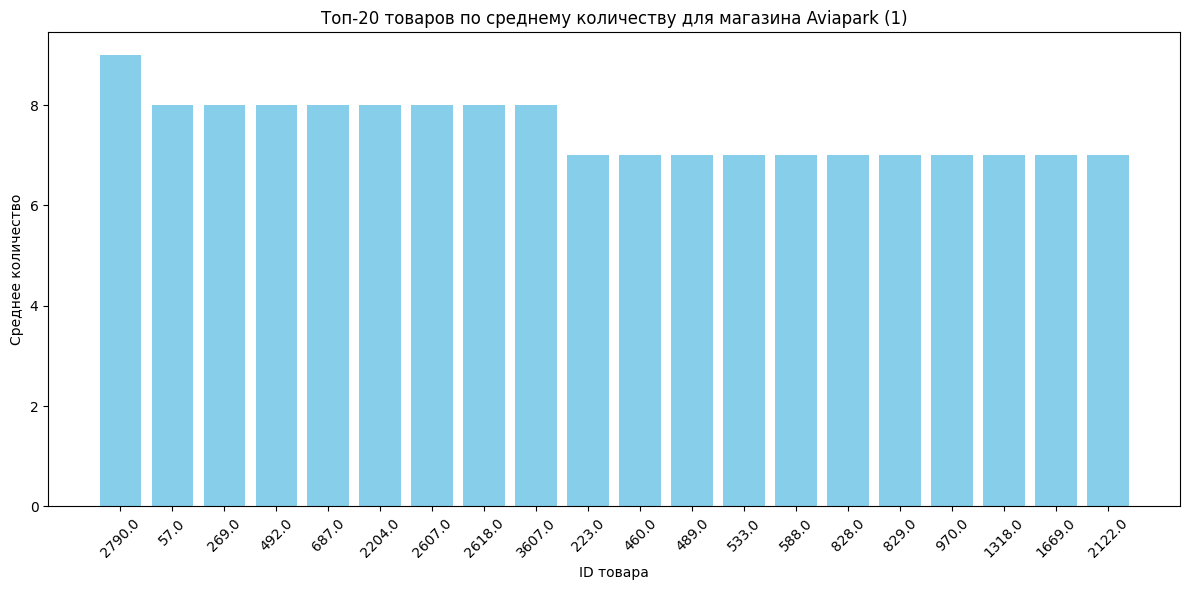

Магазин: Aviapark (1) - Товары вне топ-20
      product_id  avg_product_count
1504      1605.0                1.0
3004      3200.0                1.0
2092      2232.0                1.0
1727      1836.0                1.0
592        637.0                1.0
...          ...                ...
2065      2204.0                8.0
2446      2607.0                8.0
456        492.0                8.0
639        687.0                8.0
2620      2790.0                9.0

[3500 rows x 2 columns]


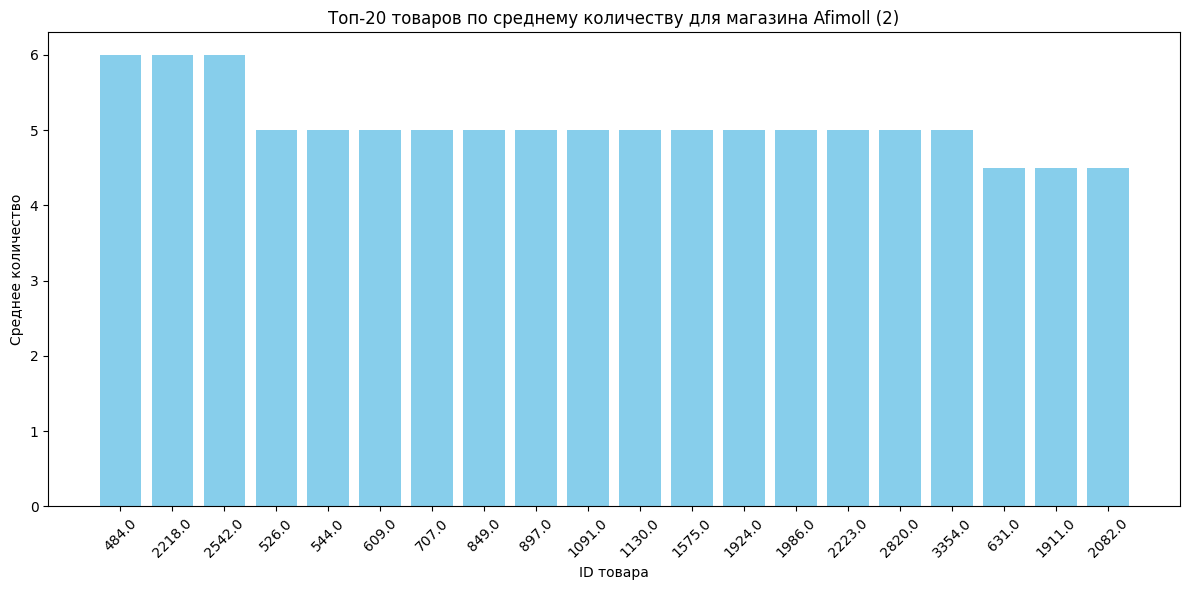

Магазин: Afimoll (2) - Товары вне топ-20
      product_id  avg_product_count
6918      3720.0                1.0
4994      1618.0                1.0
4993      1617.0                1.0
6614      3392.0                1.0
4989      1613.0                1.0
...          ...                ...
4290       849.0                5.0
4334       897.0                5.0
3946       484.0                6.0
5836      2542.0                6.0
5534      2218.0                6.0

[3419 rows x 2 columns]


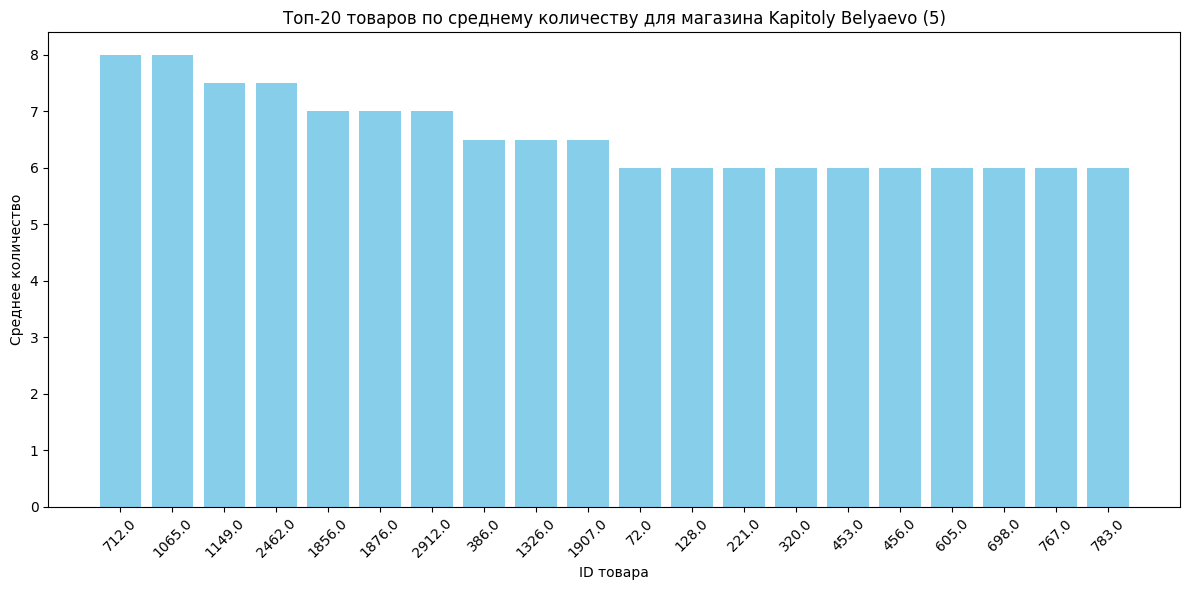

Магазин: Kapitoly Belyaevo (5) - Товары вне топ-20
       product_id  avg_product_count
8519       1626.0                1.0
8377       1478.0                1.0
10391      3527.0                1.0
8385       1486.0                1.0
8397       1498.0                1.0
...           ...                ...
9784       2912.0                7.0
9341       2462.0                7.5
8052       1149.0                7.5
7620        712.0                8.0
7968       1065.0                8.0

[3662 rows x 2 columns]


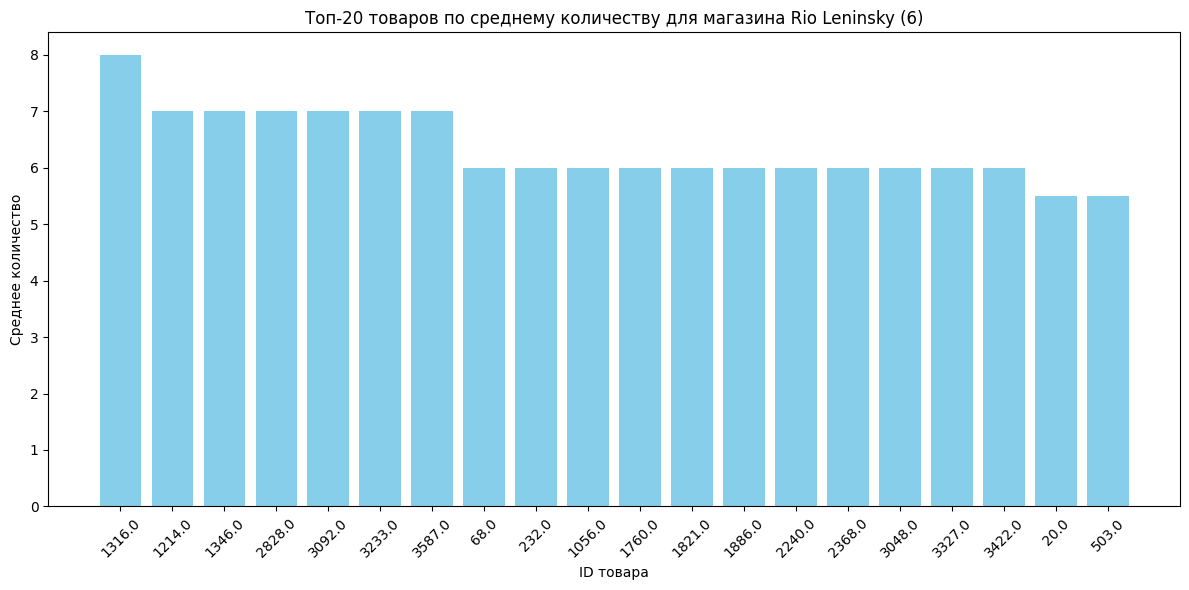

Магазин: Rio Leninsky (6) - Товары вне топ-20
       product_id  avg_product_count
13771      3266.0                1.0
13672      3165.0                1.0
11788      1233.0                1.0
13671      3164.0                1.0
11031       459.0                1.0
...           ...                ...
13600      3092.0                7.0
14077      3587.0                7.0
13345      2828.0                7.0
11901      1346.0                7.0
11871      1316.0                8.0

[3628 rows x 2 columns]


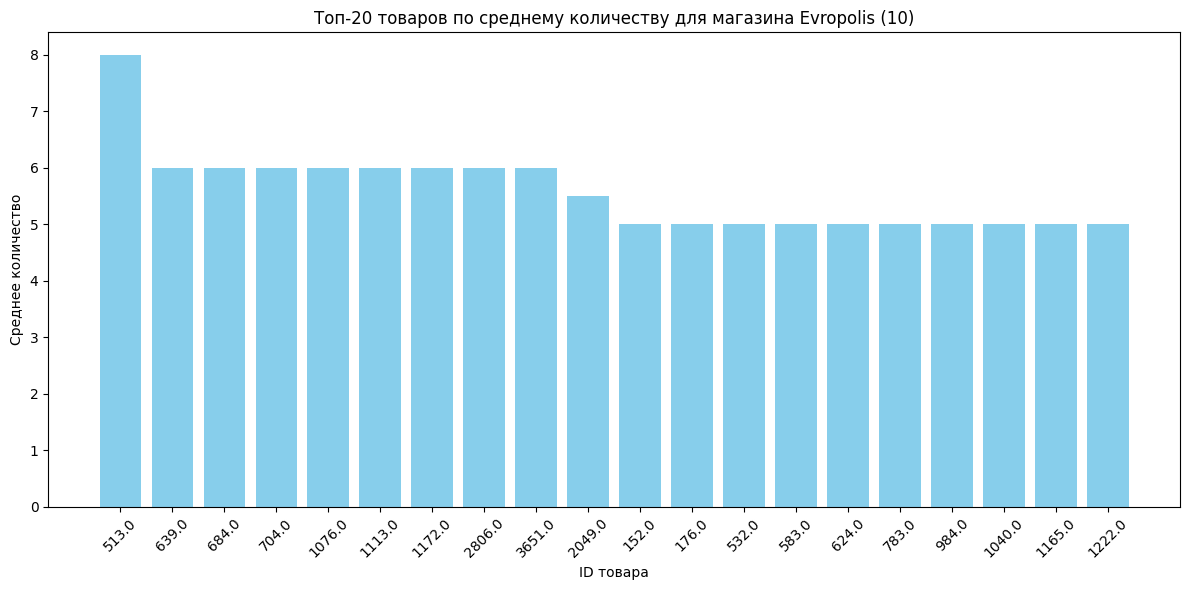

Магазин: Evropolis (10) - Товары вне топ-20
       product_id  avg_product_count
15989      1862.0                1.0
15999      1873.0                1.0
15998      1872.0                1.0
15997      1871.0                1.0
15994      1867.0                1.0
...           ...                ...
15237      1076.0                6.0
14819       639.0                6.0
15331      1172.0                6.0
14861       684.0                6.0
14701       513.0                8.0

[3561 rows x 2 columns]


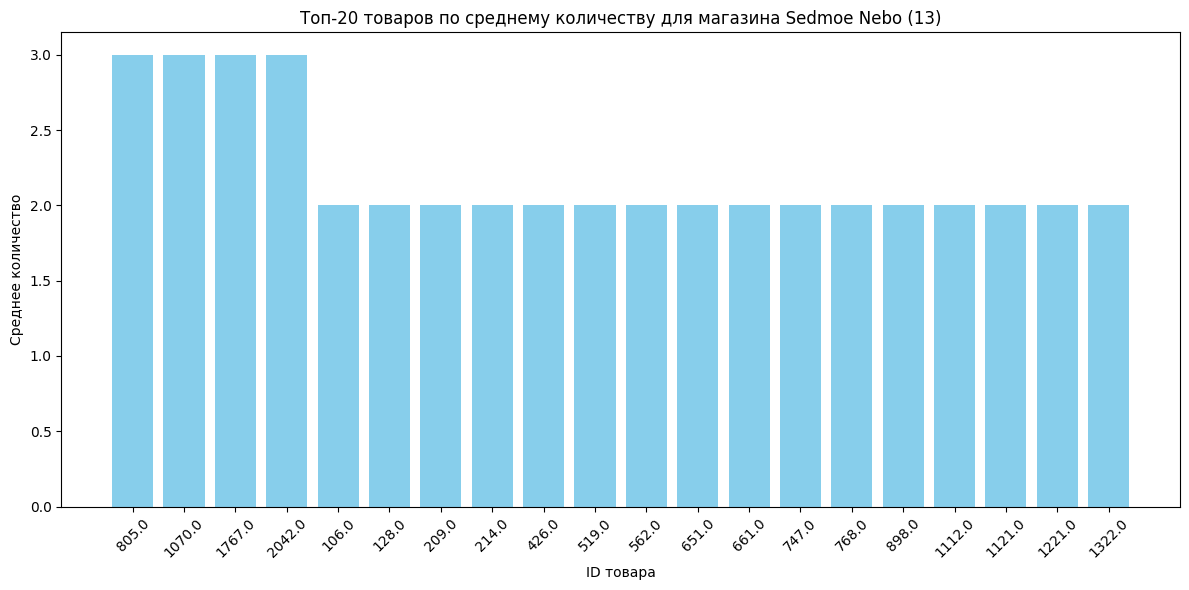

Магазин: Sedmoe Nebo (13) - Товары вне топ-20
       product_id  avg_product_count
17770         2.0                1.0
18155      2438.0                1.0
18154      2435.0                1.0
18153      2434.0                1.0
18152      2429.0                1.0
...           ...                ...
17857       519.0                2.0
18053      1767.0                3.0
18100      2042.0                3.0
17894       805.0                3.0
17930      1070.0                3.0

[575 rows x 2 columns]


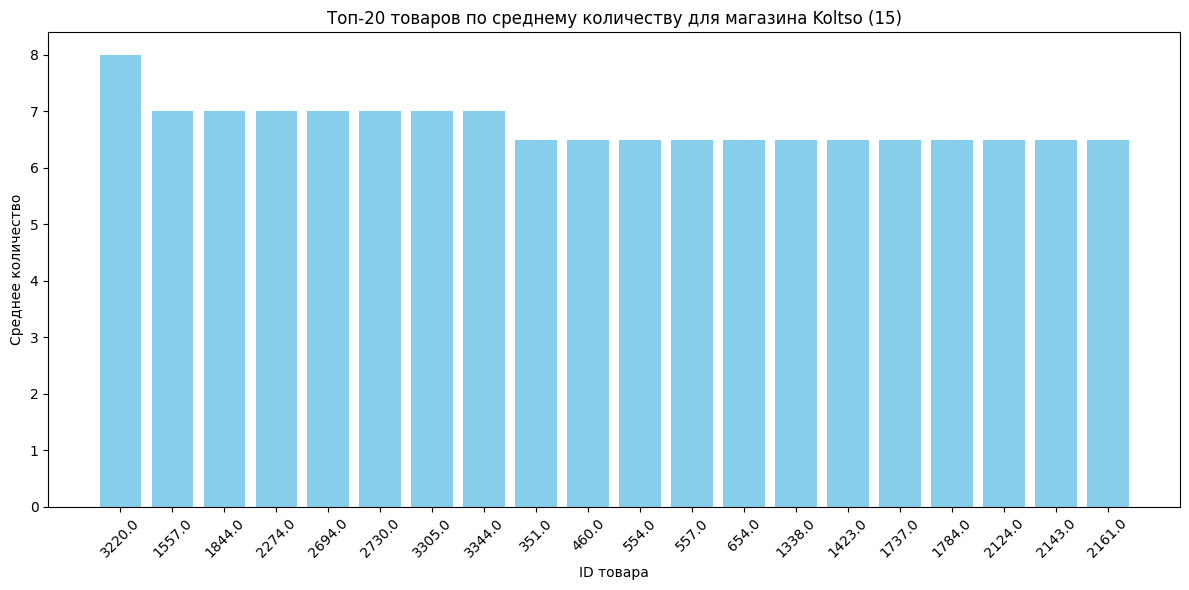

Магазин: Koltso (15) - Товары вне топ-20
       product_id  avg_product_count
19422      1093.0                1.0
21117      2810.0                1.0
18865       528.0                1.0
20122      1800.0                1.0
20129      1807.0                1.0
...           ...                ...
21608      3305.0                7.0
19883      1557.0                7.0
20165      1844.0                7.0
21002      2694.0                7.0
21523      3220.0                8.0

[3673 rows x 2 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные
orders_df = pd.read_csv('orders.csv', sep=',', dtype=str)
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')
orders_df['order_id'] = orders_df['order_id'].astype(int)
orders_df['user_id'] = orders_df['user_id'].fillna(0).astype(int)
orders_df['store_id'] = orders_df['store_id'].fillna(0).astype(int)
orders_df['month_year'] = orders_df['order_date'].dt.to_period('M')

sales_df = pd.read_csv('sales.csv', parse_dates=['purchase_date'])
sales_df['is_canceled'].fillna(False, inplace=True)
sales_df['is_accepted'].fillna(False, inplace=True)
sales_df['is_canceled'] = sales_df['is_canceled'].astype(bool)
sales_df['is_accepted'] = sales_df['is_accepted'].astype(bool)

store_df = pd.read_csv('store.csv', parse_dates=['store_open_date', 'store_close_date'])
product_df = pd.read_csv('product.csv')

# Объединяем данные о заказах и продажах
merged_df = pd.merge(orders_df, sales_df, left_on='order_id', right_on='order_id')

# Фильтруем только принятые заказы
merged_df = merged_df[merged_df['is_canceled'] == False]

# Добавляем столбец с количеством каждого товара в заказе (предположим, что он равен 1, так как таких данных нет)
merged_df['product_count'] = 1

# Группируем данные по месяцам, магазинам и товарам
grouped = merged_df.groupby(['month_year', 'store_id', 'product_id']).agg({'product_count': 'sum'}).reset_index()

# Определим последние 3 месяца на основе доступных данных
last_month = grouped['month_year'].max()
last_3_months = grouped[grouped['month_year'] >= (last_month - 2)]

# Рассчитываем среднее количество продаж каждого товара в каждом магазине за последние 3 месяца
average_sales = last_3_months.groupby(['store_id', 'product_id'])['product_count'].mean().reset_index()
average_sales.columns = ['store_id', 'product_id', 'avg_product_count']

# Объединяем с информацией о магазинах для добавления названий
average_sales = pd.merge(average_sales, store_df[['store_id', 'store_name']], on='store_id', how='left')

# Проверка наличия данных
if average_sales.empty:
    print("Нет данных для отображения.")
else:
    # Показать топ-20 товаров по среднему количеству продаж для каждого магазина
    for store in average_sales['store_id'].unique():
        store_data = average_sales[average_sales['store_id'] == store].nlargest(20, 'avg_product_count')
        other_data = average_sales[average_sales['store_id'] == store].nsmallest(len(average_sales) - 20, 'avg_product_count')
        store_name = store_data['store_name'].iloc[0] if not store_data.empty else store_df[store_df['store_id'] == store]['store_name'].iloc[0]

        plt.figure(figsize=(12, 6))
        plt.bar(store_data['product_id'].astype(str), store_data['avg_product_count'], color='skyblue')
        plt.title(f'Топ-20 товаров по среднему количеству для магазина {store_name} ({store})')
        plt.xlabel('ID товара')
        plt.ylabel('Среднее количество')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Вывод остальных товаров в виде таблицы
        print(f"Магазин: {store_name} ({store}) - Товары вне топ-20")
        if not other_data.empty:
            other_table = other_data[['product_id', 'avg_product_count']]
            print(other_table)
        else:
            print("Нет других товаров")

